# Photométrie d'Ouverture

`author` Silio-Manolo Cordelier <silio-manolo.cordelier@etu.umonpellier.fr> 

`author` Lorys Neuveux <lorys.neuveux@etu.umontpellier.fr>

`date` 18 Décembre 2025

References: *Handbook of CCD Astronomy* §5.4 ;
__[Photutils documentation #Getting Started with Photutils](https://photutils.readthedocs.io/en/stable/getting_started.html)__ ;
__[Photutils documentation #Aperture Photometry](https://photutils.readthedocs.io/en/stable/aperture.html)__

* Télecharger et vérifier l'image calibrée
* Trouver les sources avec le treshold et le rayon d'ouverture
* Trouver le meilleur rayon d'ouverture gràace au RSB pour chaque source
* Faire de la photométrie d'ouverture sur chaque source
* Convertir les coordonnées pixelisées en coordonnées réelles
* Envoie des coordonnées à l'atlas Vizier pour obtenir les magnitudes de références
* Comparer avec le résultat obtenu

In [58]:
# Importation des bibliothèques
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import ccdproc as ccdp
import astropy.units as u
import astropy.coordinates as coord

from astropy.stats import mad_std, sigma_clipped_stats
from astropy import units as u
from astropy.visualization import ZScaleInterval
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astroquery.vizier import Vizier
from scipy import optimize


warnings.filterwarnings("ignore")# Pour éviter les warnings

# Télecharger et vérifier l'image calibrée

In [59]:
filter='red'# On prend l'image rouge

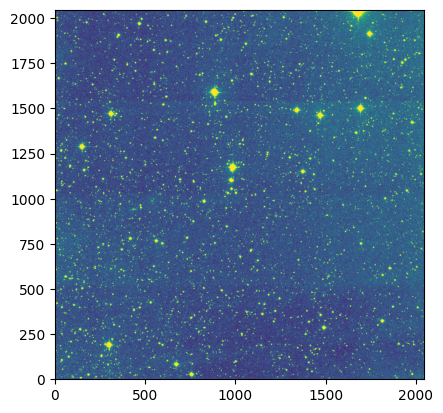

In [60]:
if filter=='red':
    path_sci = "reduced/M39_r_1.fits"
else:
    path_sci = "reduced/M39_g_1.fits"
# Permet de choisir quelle image nous allons traiter selon le filtre demandé
ccd_sci = ccdp.CCDData.read(path_sci)# On récupère les données contenues dans le dossier FITS
plt.figure()
interval = ZScaleInterval()# Ce paramètre servira d'intervalle de résolution pour notre image
z1, z2 = interval.get_limits(ccd_sci.data)# On prend donc les limites en nombre de pixels (soit, 2048 x 2048)
plt.imshow(ccd_sci, origin='lower', vmin=z1, vmax=z2)# On affiche les données en prenant soin de choisir le pixel à la position '0' en bas
plt.show()

# Recherche des Sources

In [61]:
FWHM = 1.95 # Largeur à mi-hauteur (en pixels)
trsh=100 # Avec un treshold de 100
bkg_sigma = mad_std(ccd_sci)# L'écrat-type "médian" (MAD) de notre image, nous indique donc à quel point on est écarté de la valeur médiane
bg_lvl=np.median(ccd_sci.data)# La médiane de notre image, nous donne une bonne estimation du fond de ciel
print("Background standard deviation: %.3f" % bkg_sigma)
print("Background median level: %.3f" % bg_lvl)
daofind = DAOStarFinder(fwhm=FWHM, threshold=trsh*bkg_sigma,peakmax=50000*1.339)
# Fonction permettant de trouver les étoiles en donnant un pic max, le threshold et la largeur à mi-hauteur. 
sources = daofind(ccd_sci.data)# Recherche des sources
print("%d sources found" % len(sources))
sources.sort(keys='peak')# Trier les sources en fonction de leur "tranchant"
for col in sources.colnames:
    sources[col].info.format = '%.8g'
# Permet d'afficher les données des sources avec des espaces pour la visibilité
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))# Les positions en pixels de nos sources

Background standard deviation: 3.835
Background median level: 55.627
321 sources found


# Calcul du fond de ciel pour chaque sources (choisir une des deux options)

## Fond de ciel local

In [62]:
# Il y a des zéros dans ap_sky qui sont au milieu, je dois doncles enlever à la main
def median_sky(ap_sky):
    n = np.shape(ap_sky)[0]*np.shape(ap_sky)[1]# n est la quantité de données qui se trouvent dans une ouverture du ciel
    a = np.reshape(ap_sky, n)# Je construis un array qui contient toutes mes données
    b = []# Va me permettre de stocker momentanément toutes mes données
    for i in range(0,n):
        if a[i] == 0:# On retire à la main tous les 0
            i += 1
        else : 
            b.append(a[i])
            i += 1
    return np.median(b)# On obtient alors la médiane de l'ouverture du ciel : la valeur de fond du ciel local
med_sky = np.zeros(len(positions))# On construit le array qui contiendra pour chaque étoile la valeur du fond de ciel local
for istar in range(len(positions)):# Boucle sur toutes les étoiles
    sky_aperture = CircularAnnulus(positions, r_in=4.*FWHM, r_out=6.*FWHM)
# Fonction permettant de donner l'ouverture du ciel avec un rayon intérieur et extérieur (multiples de la largeur à mi-hauteur) 
    mask_sky = sky_aperture[istar].to_mask(method='center')# Notre masque 
    ap_sky = mask_sky.multiply(ccd_sci.data)# Application du masque
    med_sky[istar] = median_sky(ap_sky)# Calcul et stockage des données des médianes


## Fond de ciel global

In [63]:
med_sky=np.full(len(positions),bg_lvl)# Dans le cas global, c'est plus simple. Simplement prendre la valeur de départ

# Calcul du meilleur paramètre d'ouverture (choisir une des trois options)

## Ponderation rapport signal sur bruit et somme des photons reçus

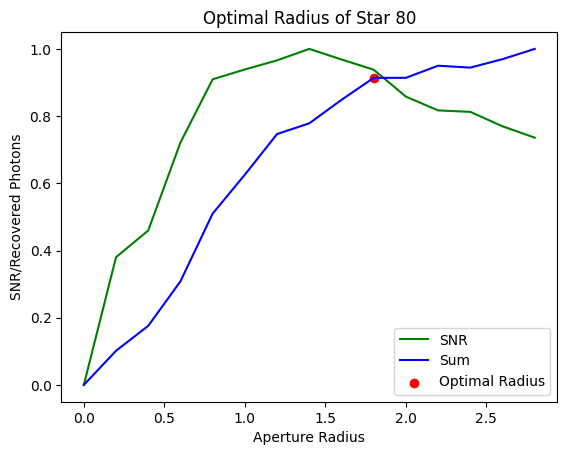

In [64]:
dark_current=0.2# Courant d'obscurité en electrons par seconde
exp_time=5# Temps d'exposition en secondes
dark_noise=dark_current*exp_time# Le bruit causé par le courant d'obscurité
ron=14.32# Bruit de lecture
npix=2048**2# Nombre de pixels

def snr(star_sum,dark_noise,read_of_noise,bg_lvl,npix):
    return star_sum/np.sqrt(star_sum+npix*(bg_lvl+dark_noise+read_of_noise**2))
# Définition du rapport signal sur bruit, voir références

def snr_plot(FWHM,sources):# Fonction permettant de tracer le rapport signal sur bruit en fonction de la source et du rayon d'ouverture
    global dark_noise,ron,npix,bg_lvl# Importation des variables locales
    s=15
    istar_excl=[]# Les étoiles que nous allons exclure
    r=np.zeros(s)# Les rayons calculés pour une étoile
    snr_array=np.zeros(s)# Tableau du rapport signal bruit
    snr_array_normalized=np.zeros(s)# Tableau du rapport signal sur bruit normalisé
    bg_corr=np.zeros(s)# Tableau de la correction du fond de ciel
    sum_star=np.zeros(s)# Tableau de la somme des photons reçus
    sum_star_corr=np.zeros(s)# Tableau de la somme des photons reçcus, corrgié du fond de ciel
    sum_star_corr_normalized=np.zeros(s)# Tableau de la somme des photons reçus, corrgié du fond de ciel, normalisé
    delta=np.ones(s)# Écart entre SNR et Sum Star
    r_opt=np.zeros(len(sources))# Tableau des rayons d'ouverture optimaux
    sum_star_opt=np.zeros(len(sources))# Tableau des SNR associés aux rayons optimaux, sert uniquement à plot le rayon optimal trouvé avec les deux autres courbes
    sum_star_opt_normalized=np.zeros(len(sources))# De même, mais normalisé
    for istar in range(len(sources)):
        for k in range(s):
            r[k]=(0.00001+ 0.2*k)# On prend des rayons de plus en plus grand
            bg_corr=np.pi*(r[k]*FWHM)**2*med_sky[istar]# Calcul de la correction de fond de ciel
            star_apertures = CircularAperture(positions, r[k]*FWHM)# Ouverture photométrique
            mask_star = star_apertures[istar].to_mask(method='center')# Création du masque
            ap_star = mask_star.multiply(ccd_sci.data)# Application du masque
            sum_star[k]=np.sum(ap_star)# Somme des photons reçus
            sum_star_corr[k]=sum_star[k]-bg_corr# Correction du fond de ciel
            snr_array[k]=snr(sum_star_corr[k],dark_noise,ron,med_sky[istar],len(ap_star)**2)# Tableau du SNR
        snr_array_normalized=snr_array/np.max(snr_array)# Normalisation
        sum_star_corr_normalized=sum_star_corr/np.max(sum_star_corr)# Normalisation
        for k in range(5,s):
            delta[k]=np.abs(snr_array_normalized[k]-sum_star_corr_normalized[k])
            # Calcul de l'écart entre SNR et Sum star, sans prendre les premières valeurs qui partent toutes les deux de 0
        r_opt[istar]=r[np.argmin(delta)]# On trouve le rayon optimal en fonciton du minimum d'écart
        sum_star_opt_normalized[istar]=sum_star_corr_normalized[np.argmin(delta)]# On trouve le SNR associé à ce rayon
        sum_star_opt[istar]=sum_star_corr[np.argmin(delta)]
        if istar==80:# Permet de choisir quelle étoile on souhaite afficher
            plt.plot(r,snr_array_normalized,label='SNR',c='g')
            plt.plot(r,sum_star_corr_normalized,label='Sum',c='b') 
            plt.scatter(r_opt[istar],sum_star_opt_normalized[istar],color='r',label="Optimal Radius") #on l'affiche 
            plt.xlabel("Aperture Radius")
            plt.ylabel("SNR/Recovered Photons")
            plt.title("Optimal Radius of Star "+str(istar))
            plt.legend(loc='lower right')
            plt.show()
    return r_opt, sum_star_opt



r_opt,sum_star_opt=snr_plot(FWHM,sources)

## Rapport signal sur bruit seulement (pic le plus faible)

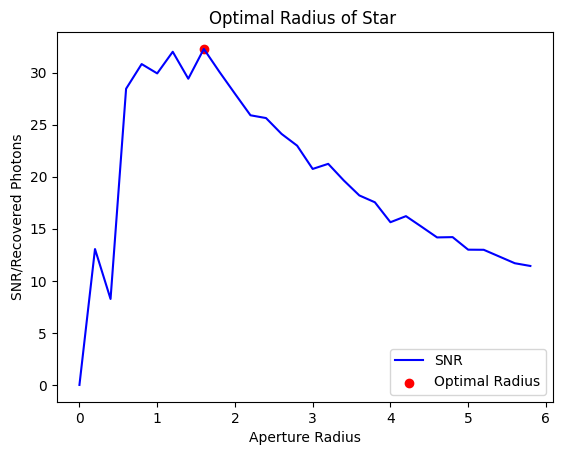

In [65]:
# Commentaires détaillés dans la subsection de la pondération entre SNR et la somme des photons
# Ici, on ne prend en compte que le rapport signal sur bruit (SNR), et on prend le même rayon optimal pour chaque étoiles, à partir du plus faible pic
dark_current=0.2
exp_time=5
dark_noise=dark_current*exp_time
ron=14.32
npix=2048**2

def snr(star_sum,dark_noise,read_of_noise,bg_lvl,npix):
    return star_sum/np.sqrt(star_sum+npix*(bg_lvl+dark_noise+read_of_noise**2))

def snr_plot(FWHM,sources):
    global dark_noise,ron,npix,bg_lvl
    s=30
    r=np.zeros(s)
    snr_array=np.zeros(s)# Tableau du rapport signal sur bruit
    sum_star=np.zeros(s)# Tableau de la somme des photons reçus
    sum_star_corr=np.zeros(s)# Tableau de la somme des photons reçus, corrgié du fond de ciel
    sum_star_opt=np.zeros(len(sources))
    # Tableau des SNR associés aux rayons optimaux, sert uniquement à plot le rayon optimal trouvé avec les deux autres courbes
    istar=0
    for k in range(s):
        r[k]=(0.00001+ 0.2*k)
        bg_corr=np.pi*(r[k]*FWHM)**2*bg_lvl # Calcul de la correction de fond de ciel
        star_apertures = CircularAperture(positions, r[k]*FWHM) # Ouverture photométrique
        mask_star = star_apertures[istar].to_mask(method='center') 
        ap_star = mask_star.multiply(ccd_sci.data)
        sum_star[k]=np.sum(ap_star) # Somme des photons reçus
        sum_star_corr[k]=sum_star[k]-bg_corr
        snr_array[k]=snr(sum_star_corr[k],dark_noise,ron,bg_lvl,len(ap_star)**2) # Tableau du SNR
    plt.plot(r,snr_array,label='SNR',color='b')
    r_opt=r[np.argmax(snr_array)] # On trouve le rayon optimal en fonciton du minimum d'écart
    plt.scatter(r_opt,np.max(snr_array),color='r',label="Optimal Radius") # On affiche le résultat
    plt.xlabel("Aperture Radius")
    plt.ylabel("SNR/Recovered Photons")
    plt.title("Optimal Radius of Star ")
    plt.legend(loc='lower right')
    plt.show()
    for istar in range(len(sources)):
        bg_corr=np.pi*(r_opt*FWHM)**2*bg_lvl # Calcul de la correction de fond de ciel
        star_apertures = CircularAperture(positions, r_opt*FWHM) #ouverture
        mask_star = star_apertures[istar].to_mask(method='center') 
        ap_star = mask_star.multiply(ccd_sci.data)
        sum_star_opt[istar]=np.sum(ap_star)-bg_corr
    #np.savetxt('snr-least luminous snr.txt', snr_array, delimiter=',')
    #np.savetxt('rayon-least lumunous snr.txt',r,delimiter=',')
    # Si l'on souhaite sauvegarder les données
    return r_opt, sum_star_opt

r_opt_temp,sum_star_opt=snr_plot(FWHM,sources)

r_opt=np.zeros(len(sources))
for k in range(len(sources)):
    r_opt[k]=r_opt_temp



## Rapport signal sur bruit seulement (pour chaque étoile)

In [66]:
# Commentaires détaillés dans la subsection de la pondération entre SNR et la somme des photons
# Ici, on ne prend en compte que le rapport signal sur bruit (SNR), et calcul le rayon optimal pour chaque étoiles
dark_current=0.2
exp_time=5
dark_noise=dark_current*exp_time
ron=14.32
npix=2048**2

def snr(star_sum,dark_noise,read_of_noise,bg_lvl,npix):
    return star_sum/np.sqrt(star_sum+npix*(bg_lvl+dark_noise+read_of_noise**2))

def snr_plot(FWHM,sources):
    global dark_noise,ron,npix,bg_lvl
    s=40
    istar_excl=[]
    r=np.zeros(s)
    snr_array=np.zeros(s)# Tableau du rapport signal bruit
    snr_array_normalized=np.zeros(s)# Tableau du rapport signal bruit, normalisé
    bg_corr=np.zeros(s)# Tableau de la correction du fond de ciel
    sum_star=np.zeros(s)# Tableau de la somme des photons reçus
    sum_star_corr=np.zeros(s)# Tableau de la somme des photons reçus, corrgié du fond de ciel
    sum_star_corr_normalized=np.zeros(s)# Tableau de la somme des photons reçus, corrgié du fond de ciel, normalisé
    delta=np.ones(s)# Écart entre SNR et Sum Star
    r_opt=np.zeros(len(sources))# Tableau des rayons d'ouverture optimaux
    sum_star_opt=np.zeros(len(sources))# Tableau des SNR associés aux rayons optimaux, sert uniquement à plot le rayon optimal trouvé avec les deux autres courbes
    sum_star_opt_normalized=np.zeros(len(sources))
    for istar in range(len(sources)):
        for k in range(s):
            r[k]=(0.00001+ 0.2*k)
            bg_corr[k]=np.pi*(r[k]*FWHM)**2*bg_lvl# Calcul de la correction de fond de ciel
            star_apertures = CircularAperture(positions, r[k]*FWHM)# Ouverture photométrique
            mask_star = star_apertures[istar].to_mask(method='center') 
            ap_star = mask_star.multiply(ccd_sci.data)
            sum_star[k]=np.sum(ap_star)# Somme des photons reçus
            sum_star_corr[k]=sum_star[k]-np.pi*(r[k]*FWHM)**2*bg_lvl #correction du fond de ciel
            snr_array[k]=snr(sum_star_corr[k],dark_noise,ron,bg_lvl,len(ap_star)**2) #tableau du SNR
        snr_array_normalized=snr_array/np.max(snr_array)# Normalisation
        sum_star_corr_normalized=sum_star_corr/np.max(sum_star_corr)# Normalisation
        for k in range(5,s):
            delta[k]=np.abs(snr_array_normalized[k]-sum_star_corr_normalized[k])
            # Calcul de l'écart entre SNR et Sum star, sans prendre les premières valeurs qui paartent toutes les deux de 0
        r_opt[istar]=r[np.argmax(snr_array)]# On trouve le rayon optimal en fonciton du minimum d'écart
        sum_star_opt_normalized[istar]=snr_array_normalized[np.argmax(snr_array)]# On trouve le SNR associé à ce rayon
        sum_star_opt[istar]=sum_star_corr[np.argmax(snr_array)]
        if istar==250:
            plt.plot(r,snr_array_normalized,label='SNR',c='g')
            plt.scatter(r_opt[istar,sum_star_opt_normalized[p],color='r',label="Optimal Radius") #on l'affiche 
            plt.xlabel("Aperture Radius")
            plt.ylabel("SNR/Recovered Photons")
            plt.title("Optimal Radius of Star "+str(istar))
            plt.legend(loc='lower right')
            plt.show()
    return r_opt, sum_star_opt



r_opt,sum_star_opt=snr_plot(FWHM,sources)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (681275887.py, line 47)

# Image de chaque source trouvée et son ouverture en fonction du rayon optimal (optionnel)

In [ ]:
for istar in range(len(positions)):# Sur toutes les étoiles
    star_aperture = CircularAperture(positions[istar,:], r=r_opt[istar]*FWHM)# Ouverture de l'étoile
    sky_aperture = CircularAnnulus(positions, r_in=5.*FWHM, r_out=7.*FWHM)# Ouverture du ciel
    mask_star = star_aperture.to_mask(method='exact')# Masque de l'étoile
    ap_star = mask_star.multiply(ccd_sci.data)# Application du masque
    mask_sky = sky_aperture[istar].to_mask(method='center')# Masque du ciel
    ap_sky = mask_sky.multiply(ccd_sci.data)# Application du masque
    #
    #np.savetxt('star0.txt',ap_star,delimiter=',',fmt='%1.5f')# Sauvegarde des données
    #
    fig = plt.figure(figsize=(9,4))
    #
    ax1 = fig.add_subplot(131)
    interval1 = ZScaleInterval()
    z1, z2 = interval1.get_limits(ap_star)# Les limites de l'image doit être celles de l'ouverture
    im1 = ax1.imshow(ap_star.data, origin='lower', vmin=z1, vmax=z2, interpolation='nearest')# On trace l'ouverture de l'étoile
    fig.colorbar(im1)
    ax1.set_title('star aperture #%d' % istar)
    #
    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(ap_sky.data, origin='lower', vmin=z1, vmax=z2, interpolation='nearest')# L'ouverture du ciel autour de l'étoile
    fig.colorbar(im2)# En prenant en compte le même intervalle de couleur
    ax2.set_title('sky aperture #%d' % istar)
    #
    ax3 = fig.add_subplot(133)
    interval2 = ZScaleInterval()# On change l'intervalle de couleur
    z1, z2 = interval2.get_limits(ap_sky)
    im3 = ax3.imshow(ap_sky.data, origin='lower', vmin=z1, vmax=z2, interpolation='nearest')# L'ouverture du ciel autour de l'étoile
    fig.colorbar(im3)
    ax3.set_title('sky aperture #%d' % istar)
    #
    plt.show()# On affiche les images pour chaque étoiles


# Calcul de la photométrie

## Envoie des coordonnées à l'atlas Vizier pour obtenir les magnitudes de références

In [ ]:
path_sci = "new-image.fits"
# Importation de la nouvelle image obtenu par Nova astrometry
fit=pf.open(path_sci)
w = WCS(fit[0].header)# Permet d'obtenir les informations pour la conversion en coordonées équatoriales
mag_ref=np.zeros(len(positions))# Définition de nos magnitues de référence
i_err=[]# Étoiles pour lesquelles, nous n'avons pas trouvé de magnitude

for istar in range(len(positions)):
    x=positions[istar,0]
    y=positions[istar,1]
    sky = w.pixel_to_world(x,y)# Conversion des coordonnées en pixel en coordonnées équatoriales
    vizier = Vizier(columns=['rmag','gmag'])# On précise les filtres que l'on souhaite
    result = vizier.query_region(coord.SkyCoord(ra=sky.data.lon, dec=sky.data.lat, unit=(u.hourangle, u.hourangle), frame='fk5'), width=(4)*0.682*FWHM*u.arcsec, catalog='I/322A/out')
    # On demande à Vizier de nous trouver les magnitudes des étoiles avec les positions trouvées
    if len(result)==0 or len(result)>1:
        print(len(result),"correspondance(s) trouvées pour l'étoile",istar)# Anomalies possibles
    else:
        if filter=='red':
            mag_ref[istar]=result[0]['rmag'].max()# Obtention de la valeur de la magnitude pour le rouge
        else:
            mag_ref[istar]=result[0]['gmag'].max()
for k in range(len(mag_ref)):
    if np.isnan(mag_ref[k])==True:
        i_err.append(k)# On regarde quelles étoiles ont donné une erreur
sum_star_opt2=np.delete(sum_star_opt,i_err)
mag_ref2=np.delete(mag_ref,i_err)
temp_pos2=np.delete(positions,i_err,axis=0)# On enlève les étoiles qui ont donné une erreur
print(len(i_err), 'ont étés ignorées au total (pas de magnitude référencée)')




## Effectuer une première calibration

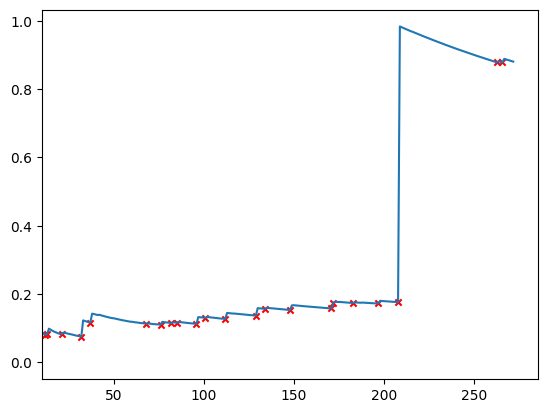

In [67]:
mag_ref3=np.flip(mag_ref2)
sum_star_opt3=np.flip(sum_star_opt2)
final_pos=np.flip(temp_pos2,axis=0)# Trie avec les peakmax les plus élevés
ind_err=[]
def m_inst(n):
    return -2.5*np.log10(n)# Définition de la magnitude instrumentale

s=len(mag_ref3)
incert=np.zeros(s)# Incertitude relative sur B
B_moy=np.zeros(s)# Moyenne de B

for nb in range(10,s):
    B = np.zeros(nb)
    for i in range(nb):
        n = sum_star_opt3[i]# Photons reçus corrigés du fond de ciel
        B[i] = mag_ref3[i] - m_inst(n)# Calcul de B
    incert[nb]=np.std(B)# Écart-type de B
    B_moy[nb]=np.mean(B)# Calcul de B pour chaque nb étoiles

Delta=np.zeros(len(B)-1)

for k in range(len(B)-1):
    Delta[k]=incert[k+1]-incert[k]# Écart entre les incertitudes

for k in range(11,len(B)-1):
    if Delta[k]>mad_std(Delta):# Si l'écart est trop grand par rapport à l'écart-type, on l'ignore
        plt.scatter(k,incert[k],s=20,c='r',marker='x')# On affiche lesquelles ont des écarts trop grand
        ind_err.append(k)
        
#np.savetxt('incert.txt',incert_relat,delimiter=',')# Sauvegarde des données
plt.plot(incert)
plt.xlim(left=10)
plt.show()

## Seconde calibration après correction des écarts

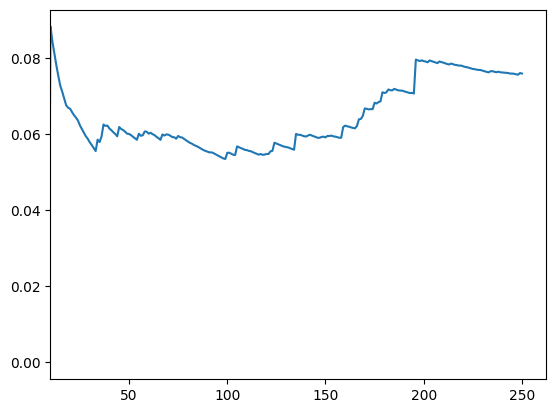

stars ignored: [12, 13, 21, 32, 37, 68, 76, 82, 85, 96, 101, 112, 129, 134, 148, 171, 172, 183, 197, 208, 263, 266]
( 22 ignored )


In [68]:
mag_ref4=np.delete(mag_ref3,ind_err)
sum_star_opt4=np.delete(sum_star_opt3,ind_err)
incert=np.zeros(len(mag_ref4))# On enlève ceux avec de trop grands écarts
B_moy=np.zeros(len(mag_ref4))
for nb in range(10,len(mag_ref4)):
    B = np.zeros(nb)
    for i in range(nb):
        n = sum_star_opt4[i]
        B[i] = mag_ref4[i] - m_inst(n)
    incert[nb]=np.std(B)
    B_moy[nb]=np.mean(B)# On recalcule B sans prendre en compte les étoiles qui donnent de trop grands écarts

#np.savetxt('incert corr.txt',incert,delimiter=',')# Sauvegarde des données
plt.plot(incert)
plt.xlim(left=10)
plt.show()
print('stars ignored:',ind_err)# Étoiles ignorées
print('(',len(ind_err),'ignored )')

## Affichage des étoiles ignorées (optionnel)

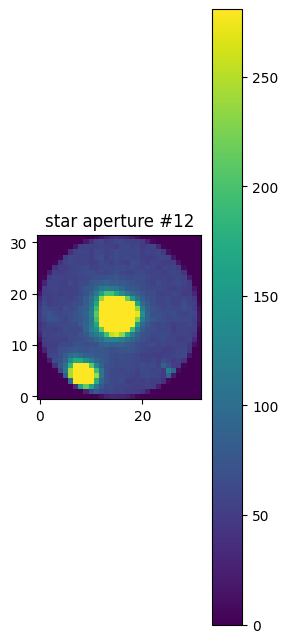

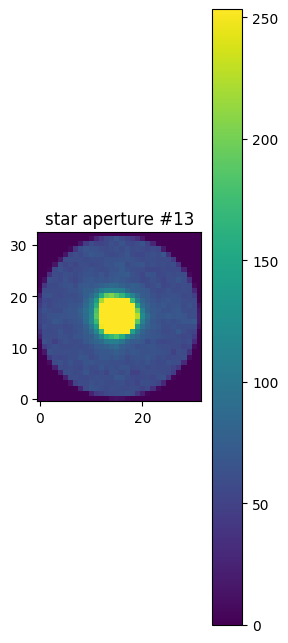

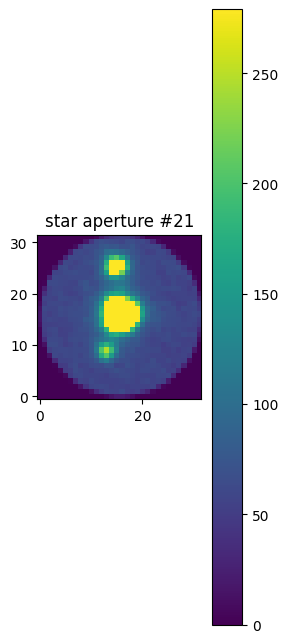

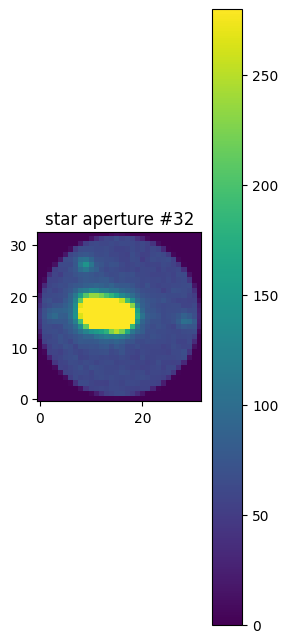

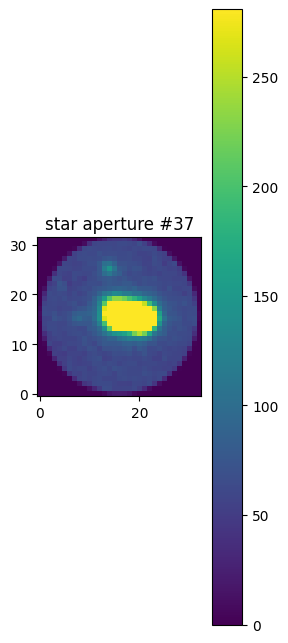

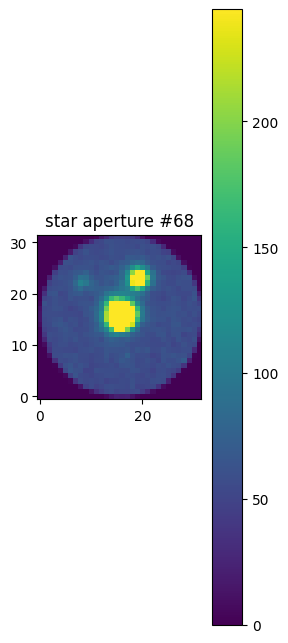

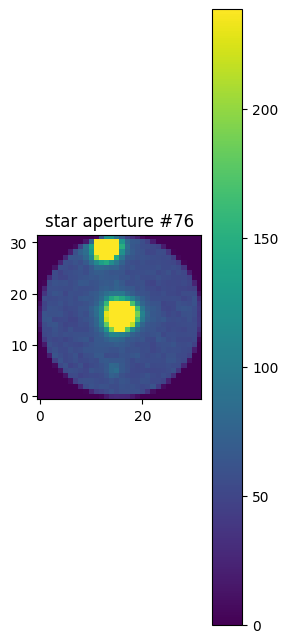

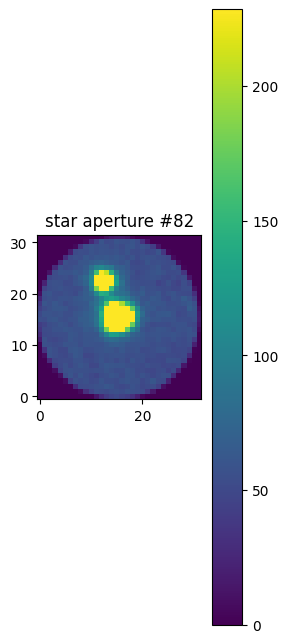

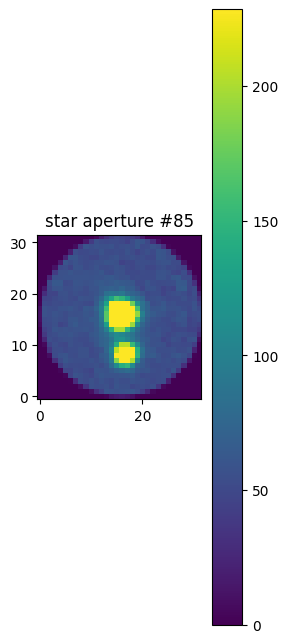

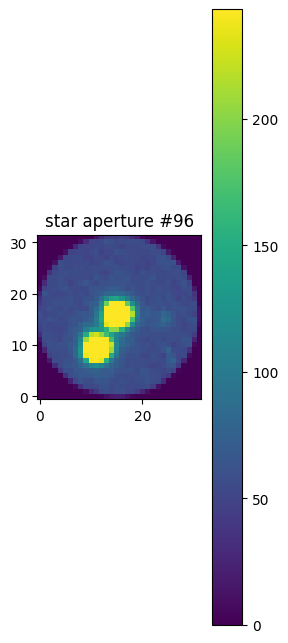

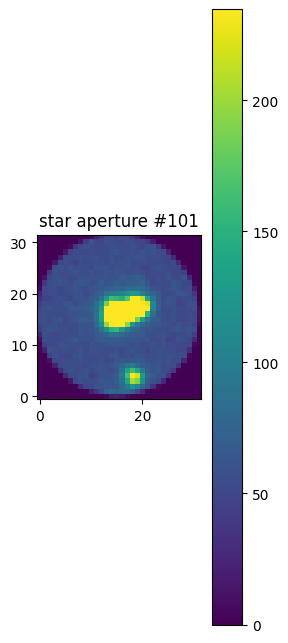

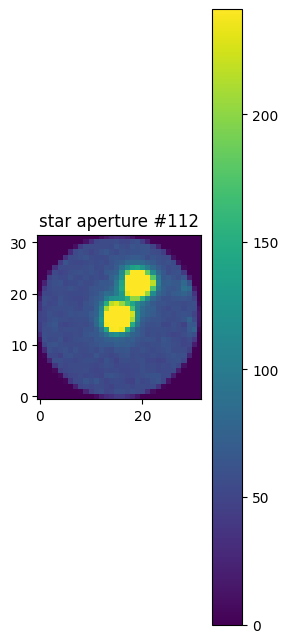

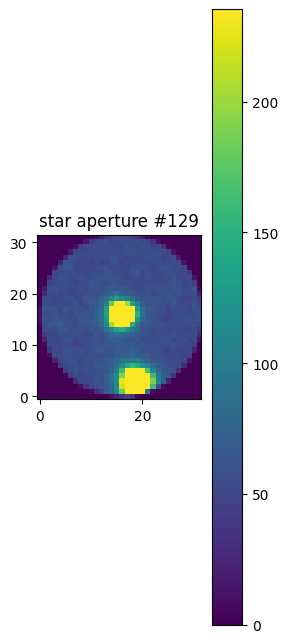

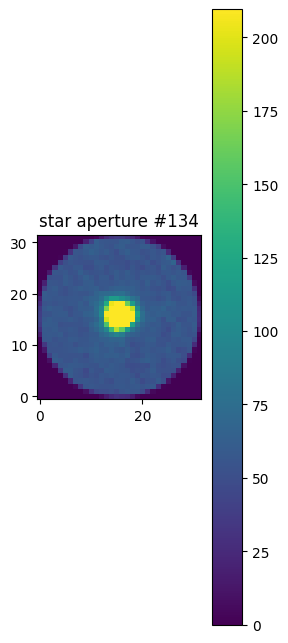

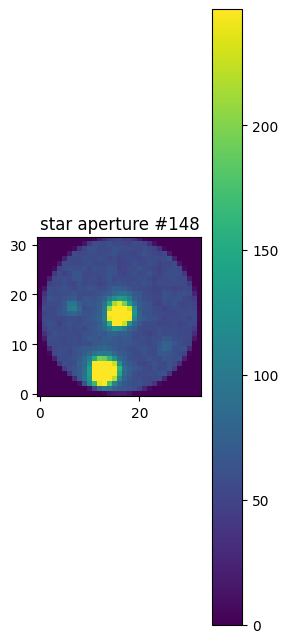

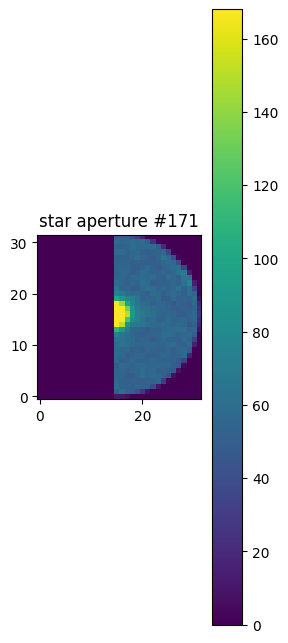

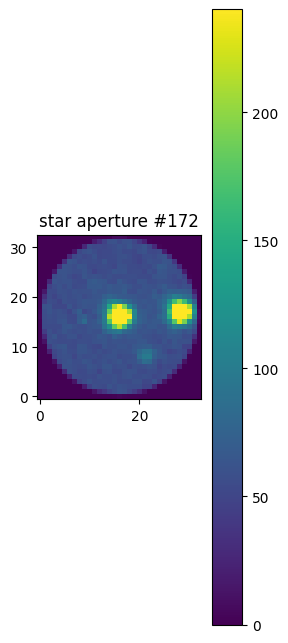

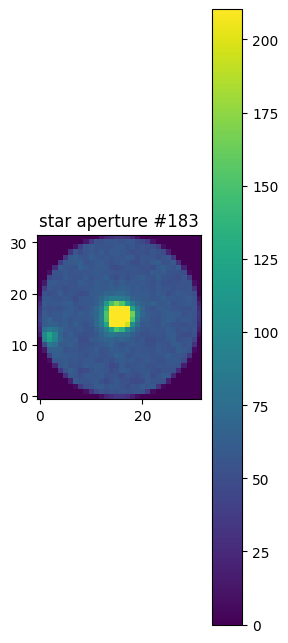

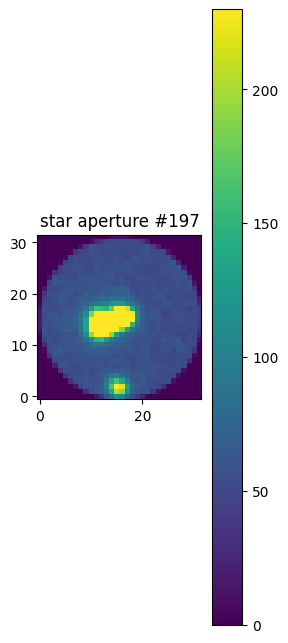

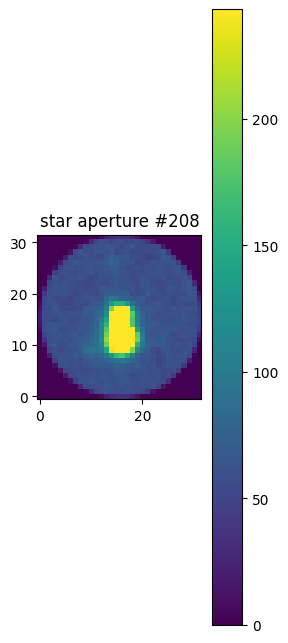

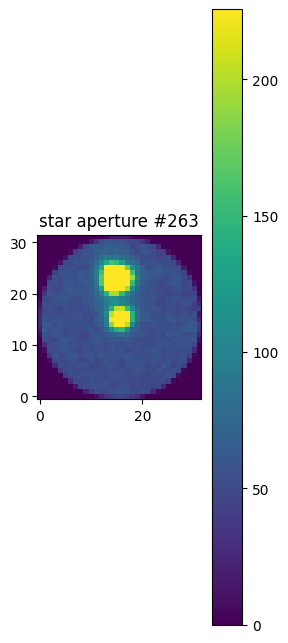

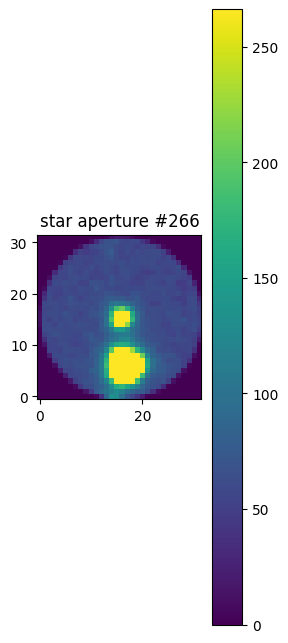

In [69]:
for istar in ind_err:# On regarde toutes les étoiles ignorées
    star_aperture = CircularAperture(final_pos[istar,:], r=8*FWHM)# Ouverture de ces étoiles
    mask_star = star_aperture.to_mask(method='exact')# Masque
    ap_star = mask_star.multiply(ccd_sci.data)# Application du masque
    np.savetxt(f'ignored star {istar}.txt',ap_star.data,delimiter=',')# Sauvegarde des données
    fig = plt.figure(figsize=(9,9))
    #
    ax1 = fig.add_subplot(131)
    interval1 = ZScaleInterval()
    z1, z2 = interval1.get_limits(ap_star)
    im1 = ax1.imshow(ap_star.data, origin='lower', vmin=z1, vmax=z2, interpolation='nearest')
    # On trace pour chaque étoile son rayon d'ouverture
    fig.colorbar(im1)
    ax1.set_title('star aperture #%d' % istar)
    
plt.show() 

## Calcul final de B

In [70]:
s=np.argmin(incert[10:])# On commence avec 10 étoiles, indice où l'incertitude est la plus faible
mags = np.zeros(s)
B = np.zeros(s)
for i in range(s):
    n = sum_star_opt4[i]
    B[i] = mag_ref4[i] - m_inst(n)
print("B(moy) = ", np.round(np.mean(B),3),"±", np.round(np.std(B),3))#c'est à la limite si on peut considérer B comme étant une constante à ce niveau là
print('r_opt=',r_opt[0])
B_final=np.mean(B)# On recalcule B dans le cas où l'incertitude est la plus faible

B(moy) =  23.812 ± 0.056
r_opt= 1.6000100000000002


## Vérification de la calibration sur des étoiles en dessous de l'ancien seuil

346 sources found


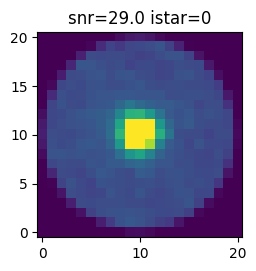

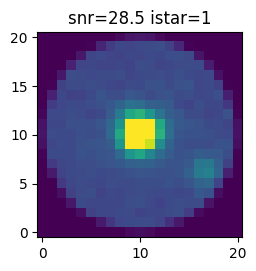

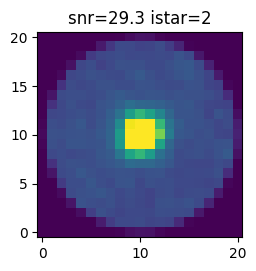

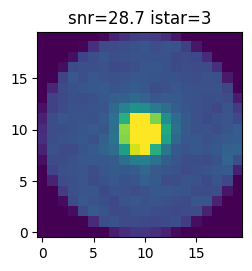

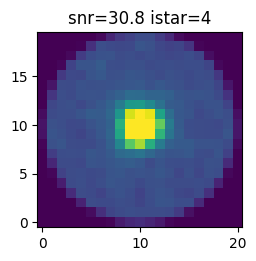

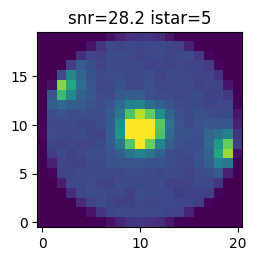

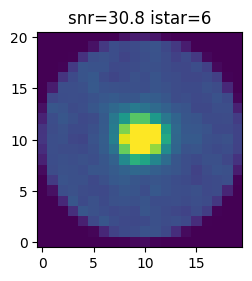

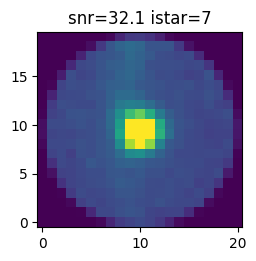

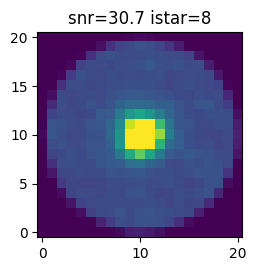

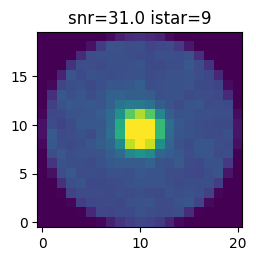

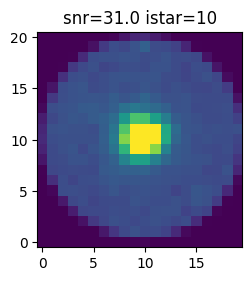

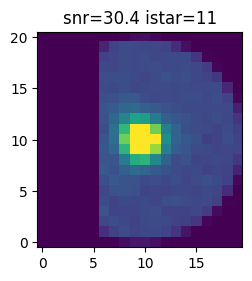

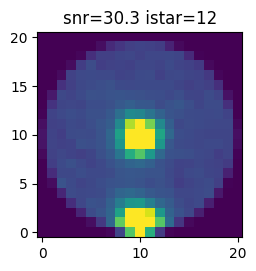

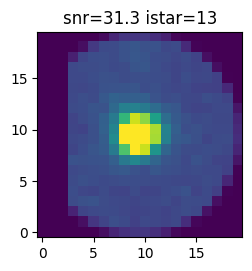

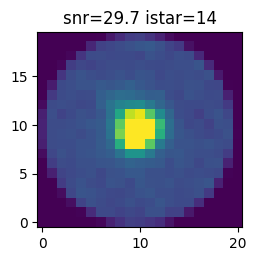

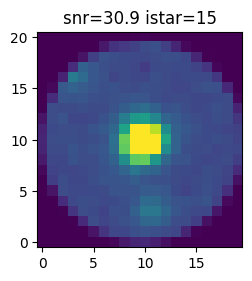

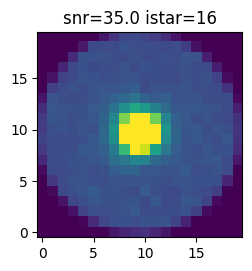

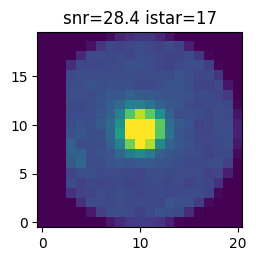

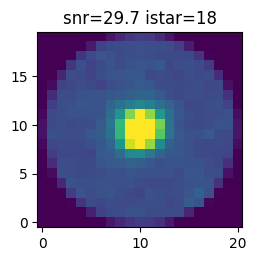

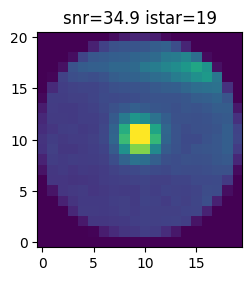

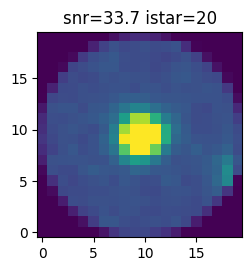

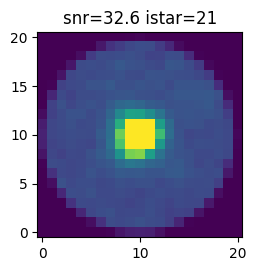

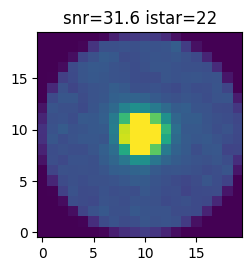

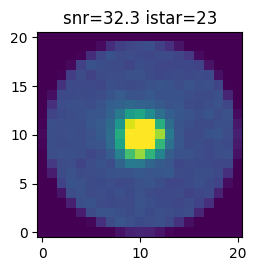

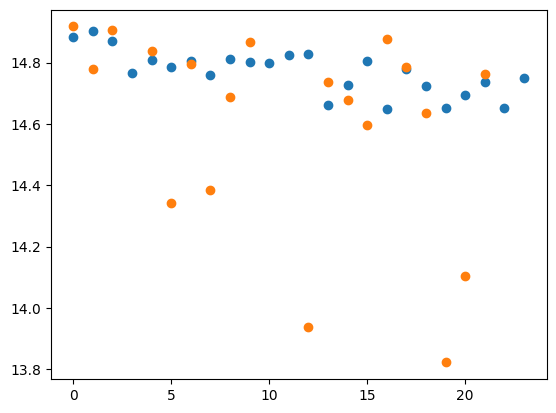

In [71]:
trsh=90# On prend donc un threshold plus faible
daofind = DAOStarFinder(fwhm=FWHM, threshold=trsh*bkg_sigma,peakmax=50000*1.339)# On trouve les étoiles
sources = daofind(ccd_sci.data)# On trouve nos sources
print("%d sources found" % len(sources))
sources.sort(keys='peak')# On trie les sources en fonction du pic 
for col in sources.colnames:
    sources[col].info.format = '%.8g'
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
test_positions=positions[1:25,:]# On prend les 25 premières qui sont nouvelles
mag=np.zeros(len(test_positions))
mag_ref=np.zeros(len(test_positions))
for istar in range(len(test_positions)):
    bg_corr=np.pi*(r_opt[0]*FWHM)**2*bg_lvl# Correction du fond de ciel
    star_apertures = CircularAperture(test_positions, r_opt[1]*FWHM) # Ouverture des étoiles
    mask_star = star_apertures[istar].to_mask(method='center')# Masque
    ap_star = mask_star.multiply(ccd_sci.data)# Application du masque
    sum_star=np.sum(ap_star)-bg_corr# On corrige le fond de ciel
    mag[istar]=m_inst(sum_star)+B_final# On calcule les nouvelles magnitudes
    snr_local=snr(sum_star,dark_noise,ron,bg_lvl,len(ap_star)**2)# Rapport signal sur bruit
    x=test_positions[istar,0]
    y=test_positions[istar,1]
    sky = w.pixel_to_world(x,y)# coordonnées équatoriales de nos étoiles
    vizier = Vizier(columns=['rmag','gmag'])# On import Vizier
    result = vizier.query_region(coord.SkyCoord(ra=sky.data.lon, dec=sky.data.lat, unit=(u.hourangle, u.hourangle), frame='fk5'), width=(4)*0.682*FWHM*u.arcsec, catalog='I/322A/out')
    if len(result)==0 or len(result)>1:
        print(len(result),"correspondance(s) trouvées pour l'étoiles",k)
    else:
        if filter=='red':
            mag_ref[istar]=result[0]['rmag'].max()# On trouve nos magnitudes par Vizier
        else:
            mag_ref[istar]=result[0]['gmag'].max()
    star_aperture = CircularAperture(test_positions[istar,:], r=5*FWHM)# Ouverture de nos étoiles
    mask_star = star_aperture.to_mask(method='exact')# Masque
    ap_star = mask_star.multiply(ccd_sci.data)# Application du masque
    fig = plt.figure(figsize=(9,9))
    #if istar in [4,5,22]:
        #np.savetxt(f'ignored star{istar}.txt',ap_star.data,delimiter=',')
    ax1 = fig.add_subplot(131)
    interval1 = ZScaleInterval()
    z1, z2 = interval1.get_limits(ap_star)
    im1 = ax1.imshow(ap_star.data, origin='lower', vmin=z1, vmax=z2, interpolation='nearest')# On affiche les ouvertures des nouvelles étoiles
    ax1.set_title('snr='+str(np.round(snr_local,1))+' istar='+str(istar))
    
plt.show() 
#np.savetxt('mag.txt',mag,delimiter=',')
#np.savetxt('mag_ref.txt',mag_ref,delimiter=',') 

plt.plot(mag,'o')
plt.plot(mag_ref,'o')
plt.show()